# **1. Importing Libraries and Installing the necessary packages.**

In [1]:
#Importing libraries
import glob
import json
import re
import collections
import random
import os
import time
import warnings
import fasttext
import datetime
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
import model as s
from PIL import Image
from tqdm import tqdm
from similarity.normalized_levenshtein import NormalizedLevenshtein
warnings.filterwarnings('ignore')

# **2. Predefined Models and variables**

In [2]:
max_length_inp_q = 41
max_length_inp_o = 220
max_length_targ = 39
batch_size=1
attention_features_shape = 64
embedding_dim=300
units=128
_,_,_,_, text, embedding_matrix = pickle.load(open('train.pkl', 'rb'))
vocab_size=len(text.word_index)+1
  
encoder = s.Encoder(vocab_size,
                  embedding_dim,
                  units,
                  batch_size,
                  embedding_matrix)
decoder = s.Decoder(vocab_size,
                  embedding_dim, 
                  units, 
                  batch_size,
                  embedding_matrix)
  
#Initializing the optimizer
optimizer = tf.keras.optimizers.Adam()
  
#Initializing the model checkpoint directory
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
checkpoint.restore(checkpoint_dir+'/ckpt-3').expect_partial()

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
  
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# **3. Function 1**

In [3]:
def function_1(X, graphs=True):
  '''
    The function_1 prints out the attention weights and the predicted outputs.
    This function takes 2(3) parameters:
      X (Dictionary) = The datapoint/s required for prediction in a dictionary format with Question, OCR and Image as keys.
      graphs (Boolean-Default parameter) = This is a parameter used for printing the attention weights if nothing is passed
  '''
  
  if graphs:
    for idx in range(len(X['Question'])):
      s.predict_answer(list(X['Question'])[idx],
                    list(X['OCR'])[idx],
                    list(X['Image'])[idx], 
                    encoder, 
                    decoder, 
                    image_features_extract_model, 
                    max_length_inp_q,
                    max_length_inp_o,
                    max_length_targ,
                    attention_features_shape,
                    units, 
                    text)
      print("\n============================================================================\n")
  else:
    for idx in range(len(X['Question'])):
      s.predict_answer(list(X['Question'])[idx],
                    list(X['OCR'])[idx],
                    list(X['Image'])[idx], 
                    encoder, 
                    decoder, 
                    image_features_extract_model, 
                    max_length_inp_q,
                    max_length_inp_o,
                    max_length_targ,
                    attention_features_shape,
                    units, 
                    text,
                    graphs)

In [4]:
X = {'Question' : [],
     'OCR' : [],
     'Image' : []}
num_of_datapoints=5
test = pd.read_csv('test.csv')
indices = random.sample(range(1, test.shape[0]), 5)
for i in indices:
  X['Question'].append(list(test['Question'])[i])
  X['OCR'].append('/'.join(list(test['OCR'])[i].split('/')[3:]))
  X['Image'].append('/'.join(list(test['Image'])[i].split('/')[3:]))

monday 



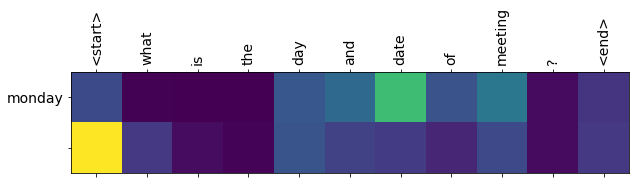

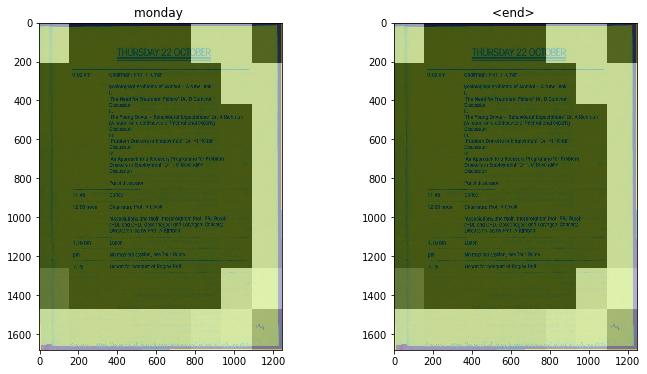



richard , and u . s . 



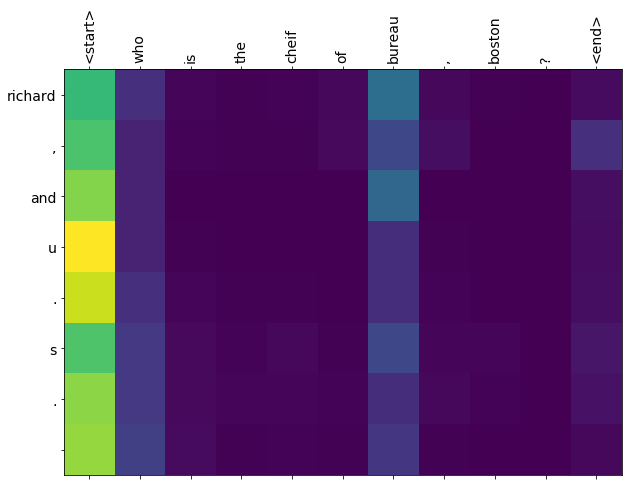

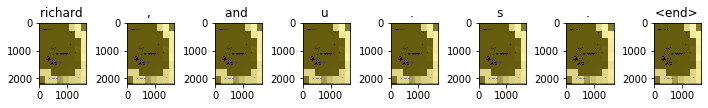



camel 



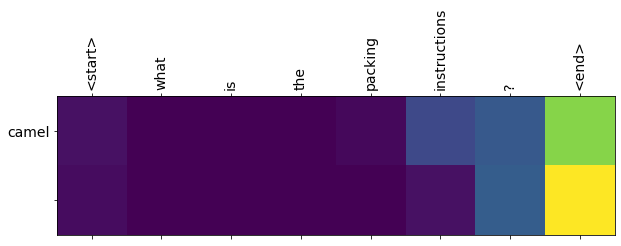

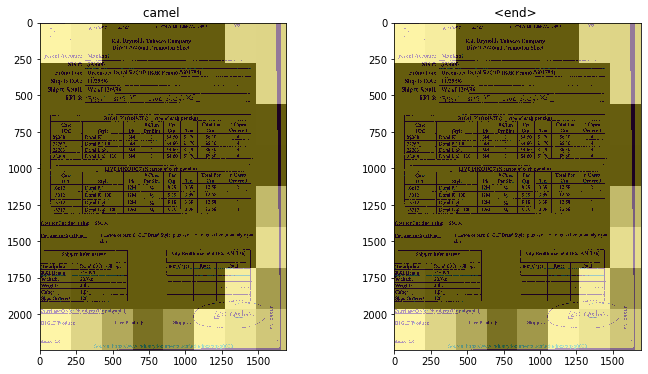



united corporation 



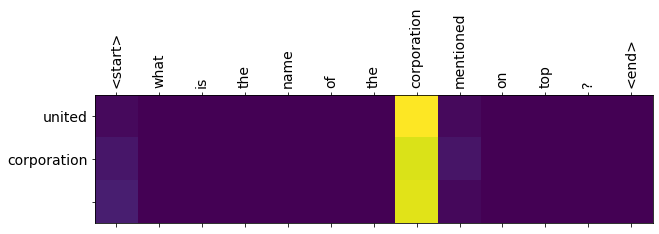

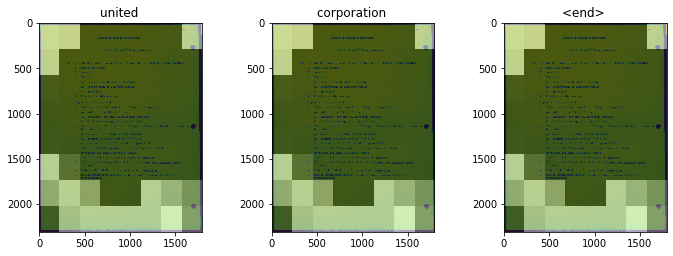



1 , 400 



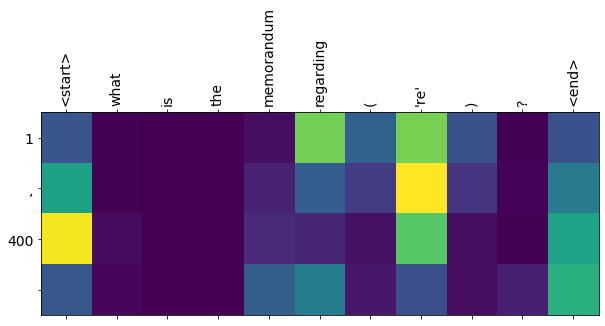

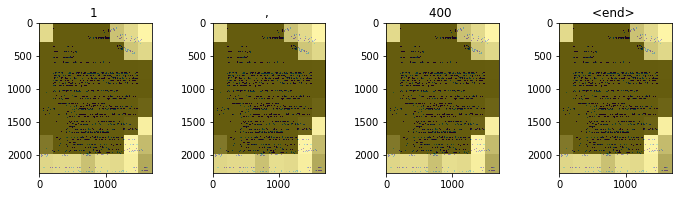



CPU times: user 7.9 s, sys: 669 ms, total: 8.57 s
Wall time: 6.16 s


In [5]:
%%time
#Printing the outputs along with attention images and time taken for predictions

#The time taken totally depends on the hardware

#Since the file transfers from google drive to colab's disk or caching it in colab's RAM 
#is time consuming at times, it might affect the total time taken
function_1(X)

In [6]:
%%time
#Printing the outputs and time taken for predictions

#The time taken totally depends on the hardware

#Since the file transfers from google drive to colab's disk or caching it in colab's RAM 
#is time consuming at times, it might affect the total time taken
function_1(X, False)

monday 

richard , and u . s . 

camel 

united corporation 

1 , 400 

CPU times: user 3.57 s, sys: 101 ms, total: 3.67 s
Wall time: 1.84 s


# **4. Function 2**

In [7]:
def function_2(X, Y, graphs=True):
  '''
    The function_2 prints out the predicted outputs, the attention weights and the ANLS score.
    This function takes 2(3) parameters:
      X (Dictionary) = The datapoint/s required for prediction in a dictionary format with Question, OCR and Image as keys.
      Y (List) = The original answers which are to be used for calculating the ANLS scores.
      graphs (Boolean-Default parameter) = This is a parameter used for printing the attention weights if nothing is passed
  '''

  #preprocessing the Y variable for a better ANLS score
  preprocessed_answers = []
  for i in tqdm(range(len(Y))):
    actual_answer = s.preprocess_qa(Y[i])
    actual_answer = actual_answer.replace('<end>','')
    actual_answer = actual_answer.replace('<start>','')
    actual_answer = actual_answer.strip()
    preprocessed_answers.append(actual_answer)  

    predicted_results = []
  
  nl = NormalizedLevenshtein()
  rho=0.5
  nl_scores = []
  # If else condition on whether the attention weights are to be output or not
  if graphs:
    for idx in range(len(X['Question'])):
      #Printing the attention weights and getting the prediction and then preprocessing it
      result = s.predict_answer(list(X['Question'])[idx],
                    list(X['OCR'])[idx],
                    list(X['Image'])[idx], 
                    encoder, 
                    decoder, 
                    image_features_extract_model, 
                    max_length_inp_q,
                    max_length_inp_o,
                    max_length_targ,
                    attention_features_shape,
                    units, 
                    text,
                    True,
                    True)
      result = result.replace('<end>','')
      result = result.strip()
      predicted_results.append(result)
      #Appending the NLS scores to a list
      if round(nl.distance(result,preprocessed_answers[idx]),1)<rho:
        nls = nl.similarity(result,preprocessed_answers[idx])
        nl_scores.append(nls)
      else:
        nls = 0.0
        nl_scores.append(nls)
      print("\n============================================================================\n")
  else:
    for idx in range(len(X['Question'])):
      #Getting the prediction and then preprocessing it
      result = s.predict_answer(list(X['Question'])[idx],
                    list(X['OCR'])[idx],
                    list(X['Image'])[idx], 
                    encoder, 
                    decoder, 
                    image_features_extract_model, 
                    max_length_inp_q,
                    max_length_inp_o,
                    max_length_targ,
                    attention_features_shape,
                    units, 
                    text,
                    graphs,
                    True)
      result = result.replace('<end>','')
      result = result.strip()
      predicted_results.append(result)
      #Appending the NLS scores to a list
      if round(nl.distance(result,preprocessed_answers[idx]),1)<rho:
        nls = nl.similarity(result,preprocessed_answers[idx])
        nl_scores.append(nls)
      else:
        nls = 0.0
        nl_scores.append(nls)

  #Printing the ANLS scores
  print('ANLS Score = ',(sum(nl_scores))/(len(nl_scores)))

In [8]:
X = {'Question' : [],
     'OCR' : [],
     'Image' : []}
Y = []
num_of_datapoints=5
val = pd.read_csv('val.csv')
indices = random.sample(range(1, val.shape[0]), 5)
val = pd.read_csv('val.csv')
for i in indices:
  X['Question'].append(list(val['Question'])[i])
  X['OCR'].append('/'.join(list(val['OCR'])[i].split('/')[3:]))
  X['Image'].append('/'.join(list(val['Image'])[i].split('/')[3:]))
  Y.append(val['Answer'][i])

100%|██████████| 5/5 [00:00<00:00, 18251.98it/s]


da - 49 - 007 - md - 1024 



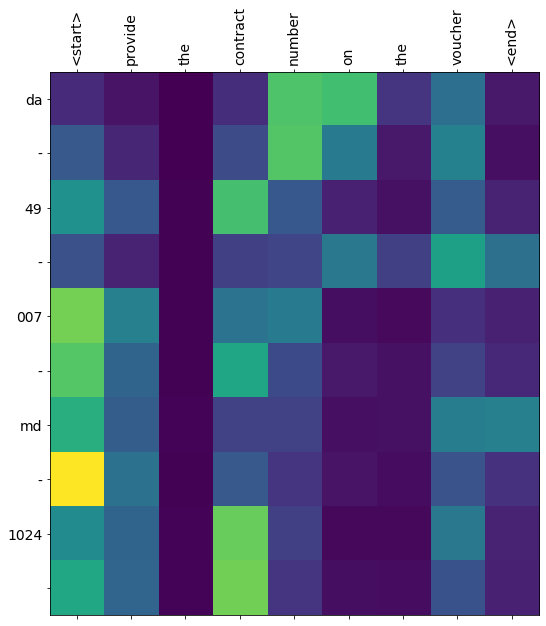

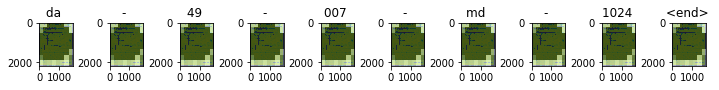



evaluation and development 



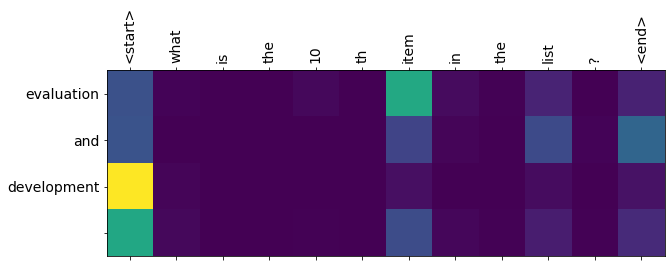

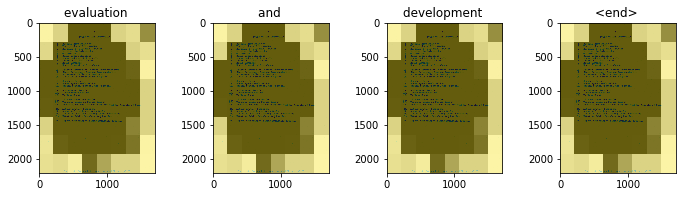



85 . 0 



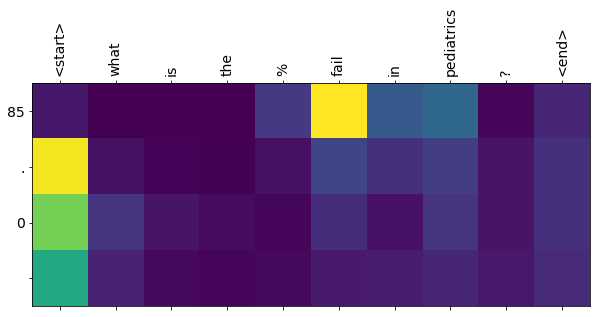

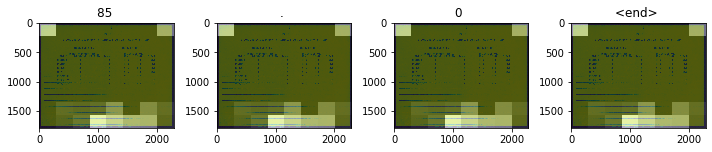



the nutrition and drug administration 



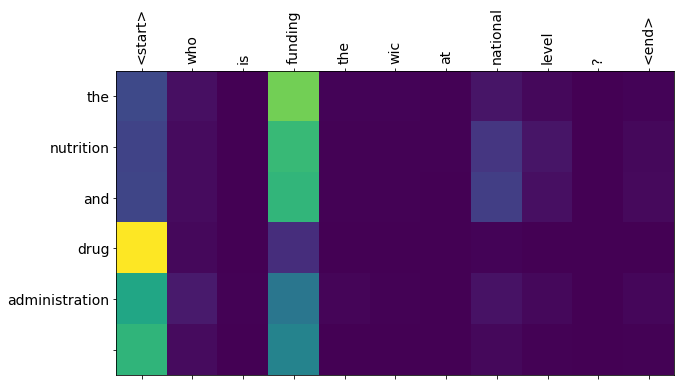

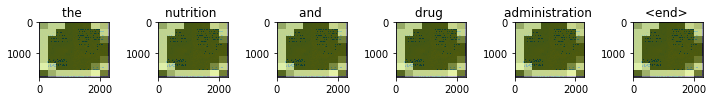



washington university 



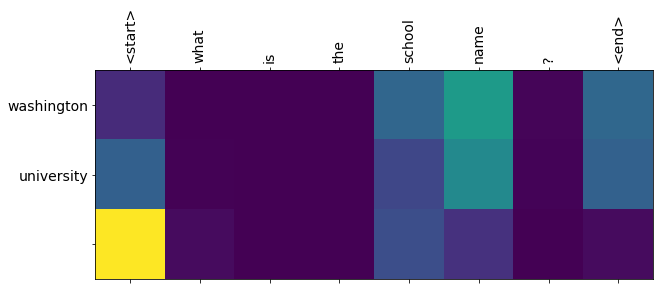

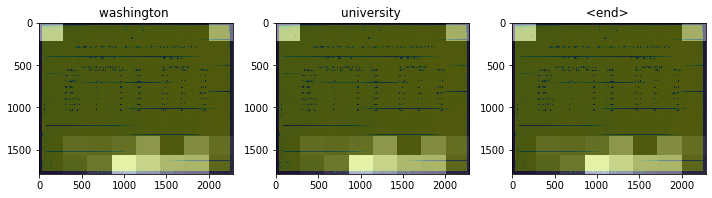



ANLS Score =  0.33333333333333337
CPU times: user 8.77 s, sys: 514 ms, total: 9.28 s
Wall time: 6.65 s


In [9]:
%%time
#Printing the outputs along with attention images and time taken for predictions

#The time taken totally depends on the hardware

#Since the file transfers from google drive to colab's disk or caching it in colab's RAM 
#is time consuming at times, it might affect the total time taken
function_2(X,Y)

In [10]:
%%time
#Printing the outputs and time taken for predictions

#The time taken totally depends on the hardware

#Since the file transfers from google drive to colab's disk or caching it in colab's RAM 
#is time consuming at times, it might affect the total time taken
function_2(X,Y,False)

100%|██████████| 5/5 [00:00<00:00, 23147.37it/s]


da - 49 - 007 - md - 1024 

evaluation and development 

85 . 0 

the nutrition and drug administration 

washington university 

ANLS Score =  0.33333333333333337
CPU times: user 3.76 s, sys: 120 ms, total: 3.88 s
Wall time: 2.05 s
